# 1.0 - IMPORTAÇÃO DE PACOTES

In [1]:
# Manipulação de Dados
import numpy as np
import pandas as pd

# Visualização de Dados
import matplotlib.pyplot as plt
import matplotlib as mpl
from pylab import rcParams

# Modelagem preditiva
import statsmodels
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.stationarity import ADFTest
from pmdarima.arima.utils import ndiffs

# Métricas e performance do Modelo
import math
from math import sqrt
import sklearn
from sklearn.metrics import mean_squared_error

# Removendo Warnings
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

## 1.0.1 - VERSÕES DOS PACOTES INSTALADOS

In [2]:
%reload_ext watermark
%watermark -a 'Versões dos pacotes instalados neste projeto' --iversions

pandas      1.1.3
matplotlib  3.3.2
numpy       1.19.2
sklearn     0.23.2
statsmodels 0.11.1
Versões dos pacotes instalados neste projeto


# 2.0 - CARREGAMENTO DO DATASET

In [3]:
dados_treino = pd.read_csv('dataset4.txt')

In [4]:
dados_teste = pd.read_csv('dataset5.txt')

In [5]:
dados_teste.head()

,ID,Datetime
0,18288,26-09-2019 00:00
1,18289,26-09-2019 01:00
2,18290,26-09-2019 02:00
3,18291,26-09-2019 03:00
4,18292,26-09-2019 04:00


In [6]:
dados_treino.head()

,ID,Datetime,Count
0,0,25-08-2017 00:00,8
1,1,25-08-2017 01:00,2
2,2,25-08-2017 02:00,6
3,3,25-08-2017 03:00,2
4,4,25-08-2017 04:00,2


# 3.0 - ANÁLISE EXPLORATÓRIA

In [7]:
df3_treino = dados_treino.copy()
df3_teste = dados_teste.copy()

#### Verificando o tipo dos dados nos Datasets de Treino e Teste

In [8]:
df3_treino.dtypes

ID           int64
Datetime    object
Count        int64
dtype: object

In [9]:
df3_teste.dtypes

ID           int64
Datetime    object
dtype: object

#### Convertendo a coluna DateTime de ambos os Datasets para o tipo correto

In [10]:
df3_treino.Datetime = pd.to_datetime(df3_treino.Datetime, format='%d-%m-%Y %H:%M')
df3_teste.Datetime = pd.to_datetime(df3_teste.Datetime, format='%d-%m-%Y %H:%M')

In [11]:
df3_treino.dtypes

ID                   int64
Datetime    datetime64[ns]
Count                int64
dtype: object

In [12]:
df3_teste.dtypes

ID                   int64
Datetime    datetime64[ns]
dtype: object

#### Derivando o máximo de detalhes da coluna 'Datetime' dos Datasets

In [13]:
for i in (df3_teste, df3_treino):
    i['ano'] = i.Datetime.dt.year
    i['mes'] = i.Datetime.dt.month
    i['dia'] = i.Datetime.dt.day
    i['hora'] = i.Datetime.dt.hour
    i['dia_semana'] = i.Datetime.dt.dayofweek

In [14]:
df3_treino.head(3)

,ID,Datetime,Count,ano,mes,dia,hora,dia_semana
0,0,2017-08-25 00:00:00,8,2017,8,25,0,4
1,1,2017-08-25 01:00:00,2,2017,8,25,1,4
2,2,2017-08-25 02:00:00,6,2017,8,25,2,4


In [15]:
df3_teste.head(3)

,ID,Datetime,ano,mes,dia,hora,dia_semana
0,18288,2019-09-26 00:00:00,2019,9,26,0,3
1,18289,2019-09-26 01:00:00,2019,9,26,1,3
2,18290,2019-09-26 02:00:00,2019,9,26,2,3


#### Removendo a coluna 'ID'dos Datasets que são irrelevantes para este projeto

In [16]:
df3_teste = df3_teste.drop(columns='ID')
df3_treino = df3_treino.drop(columns='ID') 

## 3.0.1 -  Trabalhando com o Dataset de Treino

##### Criando uma coluna categórica para Finais de Semana e Dias da Semana, onde 1 = Fim de Semana e 0 = Dia da Semana Comum

In [17]:
def fimDeSemana(registro):
    if registro.dayofweek == 5 or registro.dayofweek == 6:
        return 1
    else:
        return 0 

In [18]:
df3_treino['final_semana'] = df3_treino.Datetime.apply(fimDeSemana)

In [19]:
df3_treino.sample(5)

,Datetime,Count,ano,mes,dia,hora,dia_semana,final_semana
4957,2018-03-19 13:00:00,20,2018,3,19,13,0,0
7508,2018-07-03 20:00:00,102,2018,7,3,20,1,0
7498,2018-07-03 10:00:00,98,2018,7,3,10,1,0
5984,2018-05-01 08:00:00,26,2018,5,1,8,1,0
10982,2018-11-25 14:00:00,216,2018,11,25,14,6,1


##### Definindo com índice do Dataset a coluna 'Datetime'

In [20]:
df3_treino.index = df3_treino['Datetime']

##### Plotando um gráfico de demanda de transporte na região

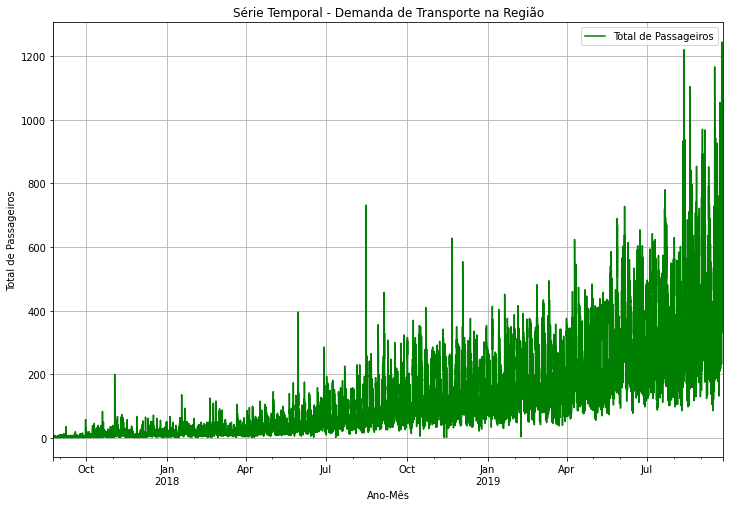

In [21]:
plt.figure(figsize=(12,8))
plt.title('Série Temporal - Demanda de Transporte na Região')
df3_treino.Count.plot(label = 'Total de Passageiros', color = 'green',grid=True )
plt.xlabel('Ano-Mês')
plt.ylabel('Total de Passageiros')
plt.legend(loc='best')
plt.show();

No gráfico acima percebe-se que há uma tendência de aumento de demanda de transporte na região.

##### Plotando um gráfico de barras da média de demanda de transporte na região por ano

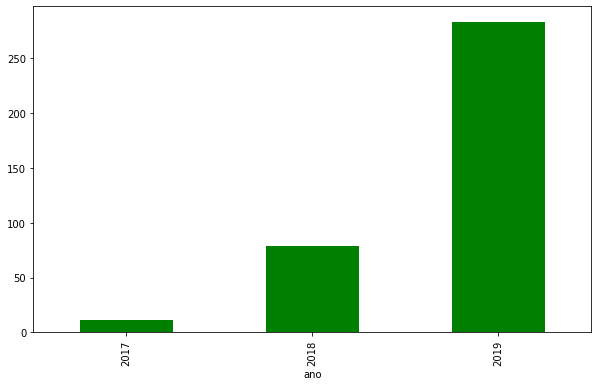

In [22]:
plt.figure(figsize=(10,6))
df3_treino.groupby('ano')['Count'].mean().plot.bar(color='green');

Mais uma vez confirmando a crescente demanda

##### Plotando um gráfico de barras com a média de demanda de transporte por mês

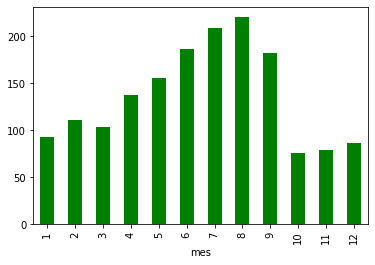

In [23]:
df3_treino.groupby('mes')['Count'].mean().plot.bar(color='green');

Pode-se observar um pico no mês de Agosto

##### Plotando um gráfico com a média de demanda de transporte mensal por ano

In [24]:
mma = df3_treino.groupby(['ano','mes'])['Count'].mean()

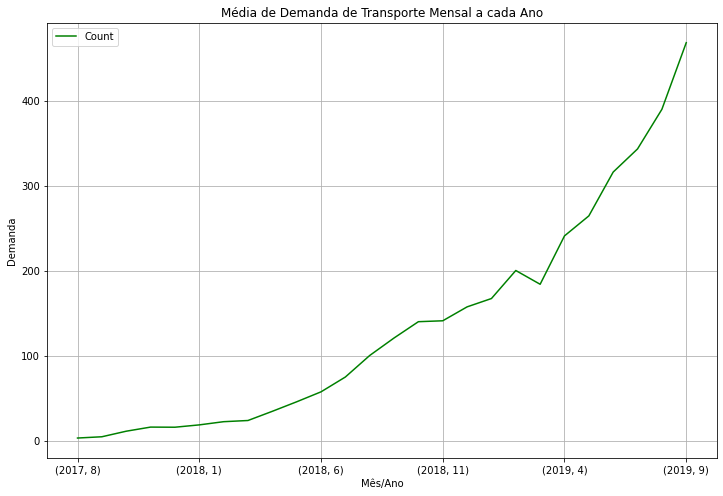

In [25]:
plt.figure(figsize=(12,8))
mma.plot(color='green', grid=True)
plt.title('Média de Demanda de Transporte Mensal a cada Ano')
plt.ylabel('Demanda')
plt.xlabel('Mês/Ano')
plt.legend(loc='best')
plt.show();

##### Plotando um gráfico com a média de demanda de transporte diária do mês

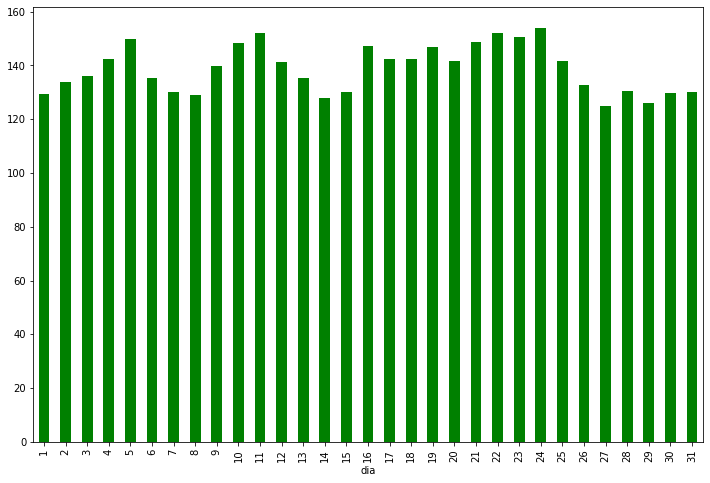

In [26]:
plt.figure(figsize=(12,8))
df3_treino.groupby('dia')['Count'].mean().plot.bar(color='green');

##### Plotando um gráfico com a média de demanda de transporte a cada hora do dia

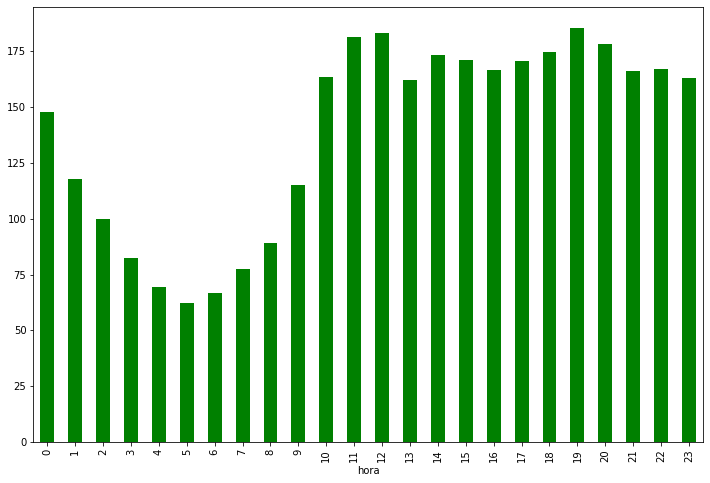

In [27]:
plt.figure(figsize=(12,8))
df3_treino.groupby('hora')['Count'].mean().plot.bar(color='green');

Observa-se que durante a madrugada a demanda cai.

##### Plotando um gráfico para analisar a demanda no final de semana X dia da semana

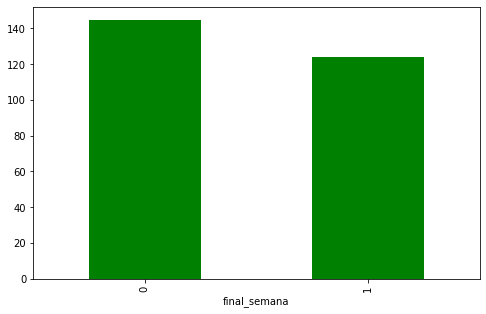

In [28]:
plt.figure(figsize=(8,5))
df3_treino.groupby('final_semana')['Count'].mean().plot.bar(color='green');

Observe que nos finais de semana a demanda cai um pouco.

##### Plotando um gráfico com 4 séries (demanda média por mês, dia, semana, hora e ano) para confirmar a tendência de crescimento.

In [29]:
media_ano = df3_treino.resample('Y').mean()
media_mes = df3_treino.resample('M').mean()
media_semana = df3_treino.resample('W').mean()
media_dia = df3_treino.resample('d').mean()
media_hora = df3_treino.resample('H').mean()

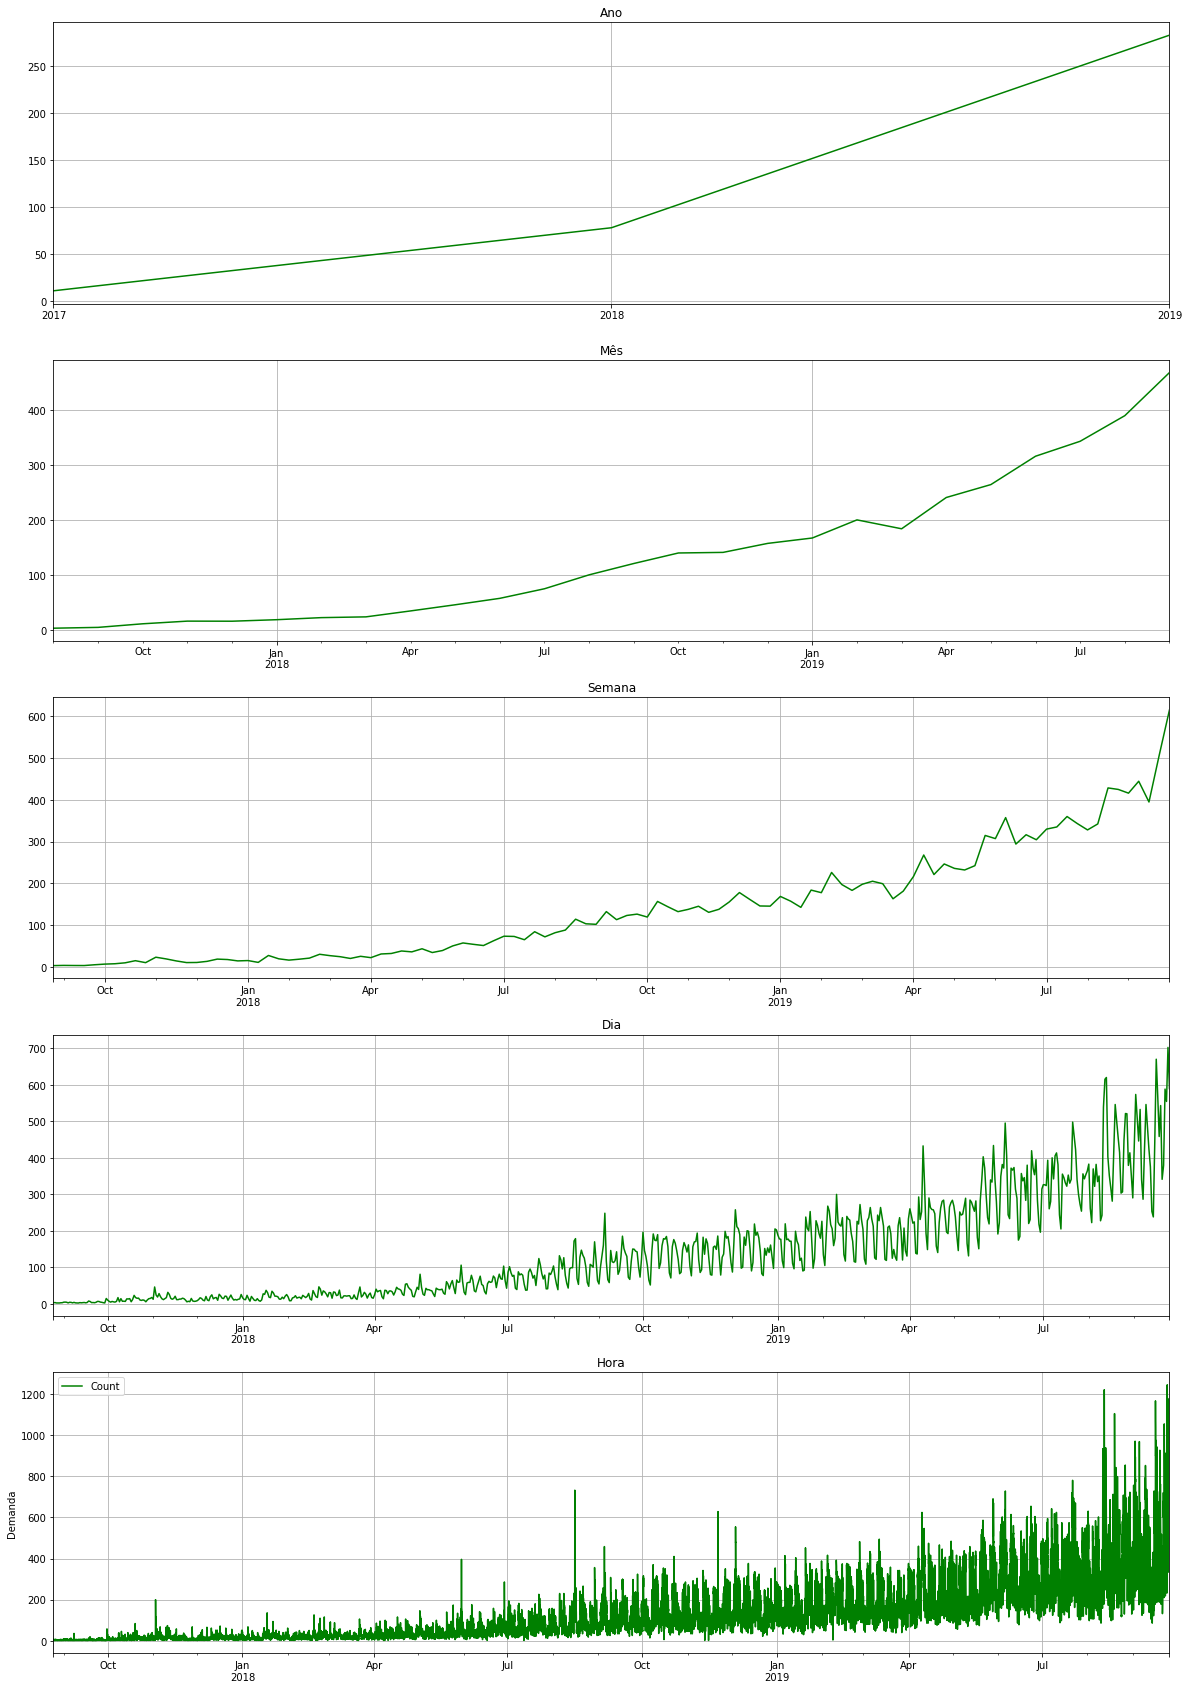

In [30]:
rcParams['figure.figsize'] = 20, 30
fig, axs = plt.subplots(5,1);
media_ano.Count.plot(title='Ano', ax=axs[0], color='green', xlabel='', grid=True);
media_mes.Count.plot(title='Mês', ax=axs[1], color='green', xlabel='', grid=True);
media_semana.Count.plot(title='Semana', ax=axs[2], color='green', xlabel='', grid=True);
media_dia.Count.plot(title='Dia', ax=axs[3], color='green', xlabel='', grid=True);
media_hora.Count.plot(title='Hora', ax=axs[4], color='green', xlabel='', grid=True);
plt.ylabel('Demanda')
plt.legend(loc='best');
plt.show();

## 3.0.2 - Verificando a Estacionareidade da Série

##### Função para testar a estacionareidade de uma série temporal

In [31]:
def estacionareidade(serie):
    # Estatisticas móveis
    rolmean = serie.rolling(window=12).mean()
    rolstd = serie.rolling(window=12).std()
    
    # Plot das estatísticas móveis
    plt.figure(figsize=(12,8))
    original = serie.plot(color='green', label='Original', grid=True)
    mean = rolmean.plot(color='red', label='Média Móvel', grid=True)
    std = rolstd.plot(color='gray', label='Desvio Padrão Móvel', grid=True)
    plt.legend(loc='best')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão')
    plt.show();
    
    # Teste Dickey-Fuller
    print(' RESULTADO DO TESTE DICKEY-FULLER '.center(50,'='))
    print('\n')
    dfteste = adfuller(serie, autolag = 'AIC')
    dfsaida = pd.Series(dfteste[0:4], index=['Estatística do Teste',
                                             'Valor-p',
                                             'Número de Lags Consideradas',
                                             'Número de Observações Usadas',])
    for key, value in dfteste[4].items():
        dfsaida[f'Valor crítico {key}'] = value
    
    print(dfsaida)
    
    # Testando o valor-p
    print('\n')
    print(' CONCLUSÃO DO TESTE '.center(50,'='))
    print('\n')
    if dfsaida[1] > 0.05:
        print('O valor-p é maior que 0.05 e portanto essa série provavelmente NÃO é estacionária')
    else:
        print('O valor-p é menor que 0.05 e portanto essa série provavelmente É estacionária') 

##### Aplicando a função de teste de estacionareidade da série

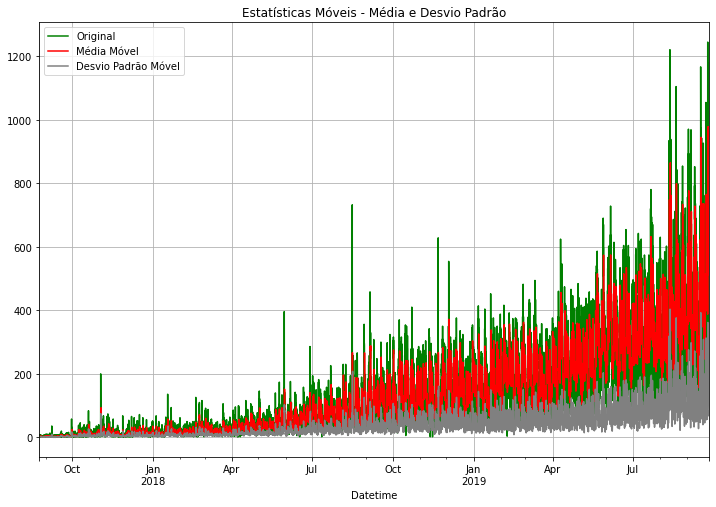

======== RESULTADO DO TESTE DICKEY-FULLER ========


Estatística do Teste               -4.456561
Valor-p                             0.000235
Número de Lags Consideradas        45.000000
Número de Observações Usadas    18242.000000
Valor crítico 1%                   -3.430709
Valor crítico 5%                   -2.861698
Valor crítico 10%                  -2.566854
dtype: float64


=============== CONCLUSÃO DO TESTE ===============


O valor-p é menor que 0.05 e portanto essa série provavelmente É estacionária


In [32]:
estacionareidade(df3_treino.Count)

##### Decompondo a série

In [33]:
decomp = seasonal_decompose(df3_treino.Count)

##### Extraindo cada coponente da série

In [34]:
trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

##### Plotando um gráfico dos componentes separados

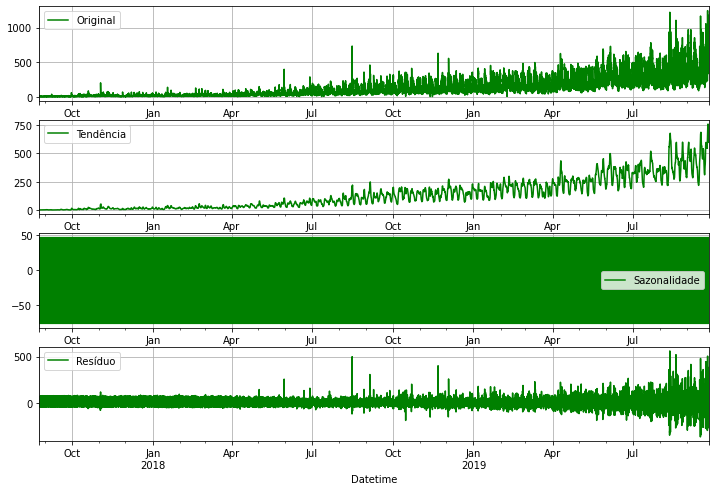

In [35]:
plt.figure(figsize=(12,8))
plt.subplot(411)
df3_treino.Count.plot(color='green', label='Original', grid=True)
plt.legend(loc='best')
plt.subplot(412)
trend.plot(color='green', label='Tendência', grid=True)
plt.legend(loc='best')
plt.subplot(413)
seasonal.plot(color='green', label='Sazonalidade', grid=True)
plt.legend(loc='best')
plt.subplot(414)
residual.plot(color='green', label='Resíduo', grid=True)
plt.legend(loc='best')
plt.show();

Observe que nesta série não existe sazonalidade, porém há uma leve tendência positiva e algum ruído. Dependendo do modelo a ser utilizado, será necessário remover a tendência.

# 4.0 - PRÉ-PROCESSAMENTO

In [36]:
df4_treino = df3_treino.copy()

In [37]:
df4_treino.shape

(18288, 8)

##### Dividindo em ordem cronológica dados de treino (70%) e dados de validação (30%)

In [38]:
df4_treino = df3_treino.iloc[0:16057]
df4_valida = df3_treino.iloc[16058:] 

In [39]:
df4_treino.shape , df4_valida.shape

((16057, 8), (2230, 8))

# 5.0 - FORECASTING

In [40]:
df5_treino = df4_treino.copy()
df5_valida = df4_valida.copy()

## 5.0.1 - Modelo Base (NAIVE)

O modelo NAIVE utiliza um método simples porém serve como base de comparação para a implementação de modelos mais sofisticados para a série temporal.

Está técnica é uma estimativa na qual os dados reais do último período são usados como previsão sem qualquer ajuste.

##### Criando um array com os valores da variável target (coluna 'Count')

In [41]:
previsao = np.asarray(df5_treino.Count)

In [42]:
previsao

array([  8,   2,   6, ..., 352, 390, 332])

In [43]:
real = df5_valida.copy()

In [44]:
real['Previsao'] = previsao[len(previsao) - 1]

In [45]:
real[['Count','Previsao']].head(15)

,Count,Previsao
Datetime,,
2019-06-25 02:00:00,218,332
2019-06-25 03:00:00,244,332
2019-06-25 04:00:00,168,332
2019-06-25 05:00:00,140,332
2019-06-25 06:00:00,156,332
2019-06-25 07:00:00,244,332
2019-06-25 08:00:00,322,332
2019-06-25 09:00:00,338,332
2019-06-25 10:00:00,444,332


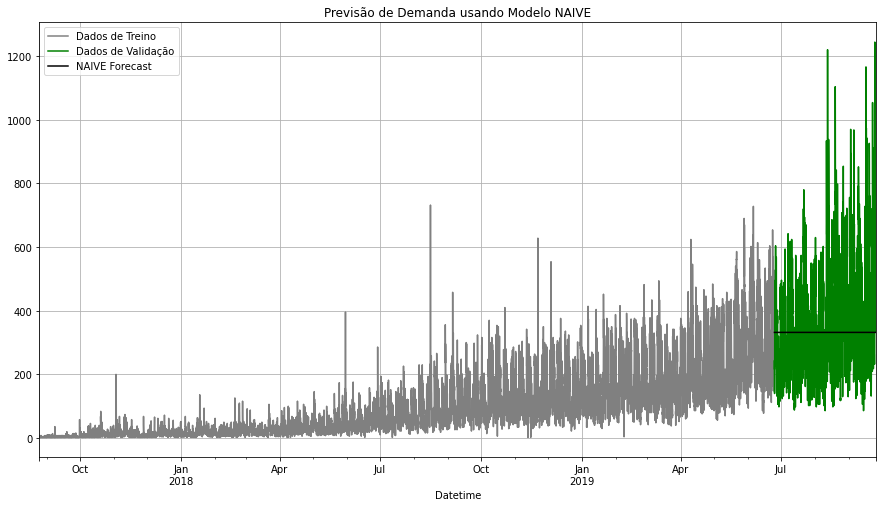

In [46]:
rcParams['figure.figsize'] = 15, 8
plt.title('Previsão de Demanda usando Modelo NAIVE')
df5_treino.Count.plot(label = 'Dados de Treino', color='gray', grid=True)
df5_valida.Count.plot(label = 'Dados de Validação', color='green', grid=True)
real.Previsao.plot(label = 'NAIVE Forecast', color='black', grid=True)
plt.legend(loc='best')
plt.show();

In [47]:
rmse_v0 = math.sqrt(mean_squared_error(real.Count, real.Previsao))

In [48]:
print(rmse_v0)

195.06210118417584


## 5.0.2 - Modelo ARIMA

### 5.0.2.1 -  Determinando os valores p,d,q do modelo

#### Valor d (ordem da diferenciação)

1 - Verificando se a série é estacionária (Teste Dickey-Fuller)

In [49]:
resultado = adfuller(dados_treino.Count)
print(f'Estatística ADF: {resultado[0]}')
print(f'Valor-p: {resultado[1]}')

Estatística ADF: -4.456560536856819
Valor-p: 0.00023540466467665785


Observe que o valor-p é < 0.05 portanto a série é estacionária, ou seja, o parâmetro d do modelo ARIMA será igual a 0. Porém para ter certeza vamos realizar mais dois testes com a função ndiffs (ADF, KPSS)

In [50]:
# Teste ADF
ndiffs(dados_treino.Count, test='adf')

0

In [51]:
# Teste KPSS
ndiffs(dados_treino.Count, test='kpss')

1

Observe que o Teste KPSS determinou o parâmetro d igual a 1. Optarei em deixar o parâmetro d igual a 1.

#### Valor p (analisando gráficos PACF)

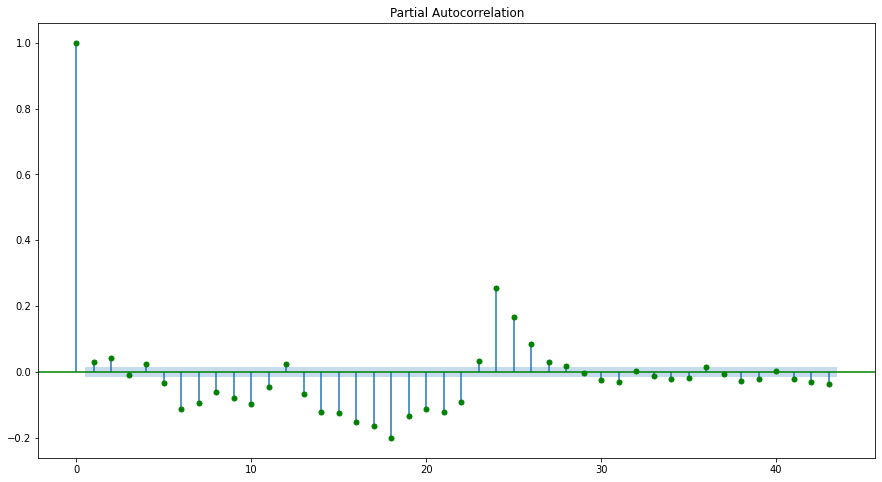

In [52]:
plot_pacf(np.diff(dados_treino.Count), color='green')
plt.show();

Para encontrar o valor p analisando o gráfico PACF é muito simples, basta verificar quantos lollipops estão fora do limite de significância contando a partir do segundo (exclusivo) até o lollipop que está totalmente dentro do limite. Observe que temos 1 lollipops. Então utilizaremos o parâmetro p igual a 1.

#### Valor q (analisando gráficos ACF)

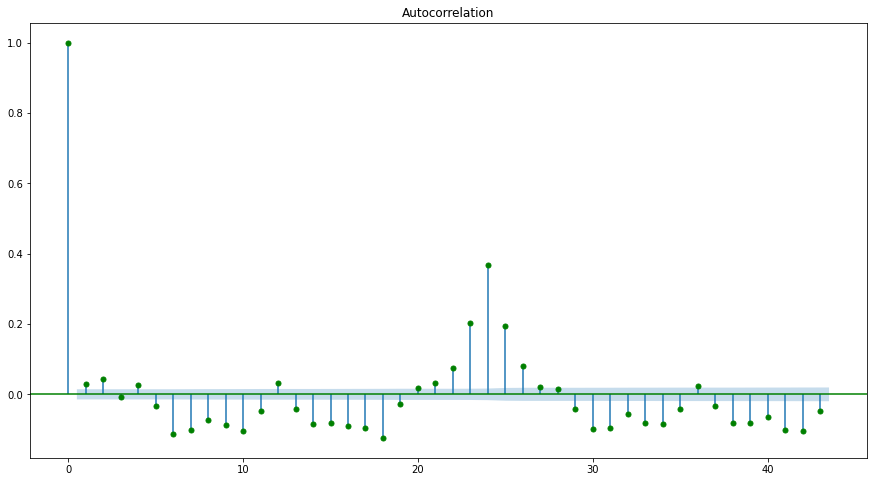

In [53]:
plot_acf(np.diff(dados_treino.Count), color='green')
plt.show();

Para encontrar o valor q analisando o gráfico ACF é muito simples, basta verificar quantos lollipops estão fora do limite de significância contando a partir do segundo (exclusivo) até o lollipop que está totalmente dentro do limite. Observe que temos 1 lollipops. Então utilizaremos o parâmetro q igual a 1.

### 5.0.2.2 -  Preparando os dados para o modelo

#### Aplicando a transformação de log

In [80]:
df5_treino_log = np.log(df5_treino.Count)

#### Aplicando a diferenciação que conforme testes acima será de 1ª ordem

In [85]:
df5_treino_log_diff = df5_treino_log - df5_treino_log.shift(1)

##### Criando e treinando o modelo

In [135]:
modelo_arima = ARIMA(df5_treino_log, order=(1,1,1), freq='H')

In [136]:
modelo_v1 = modelo_arima.fit()

##### Previsão do modelo

In [137]:
dados_reais = df5_treino_log_diff
previsoes = modelo_v1.fittedvalues

##### Plotando o gráfico com a previsão do modelo

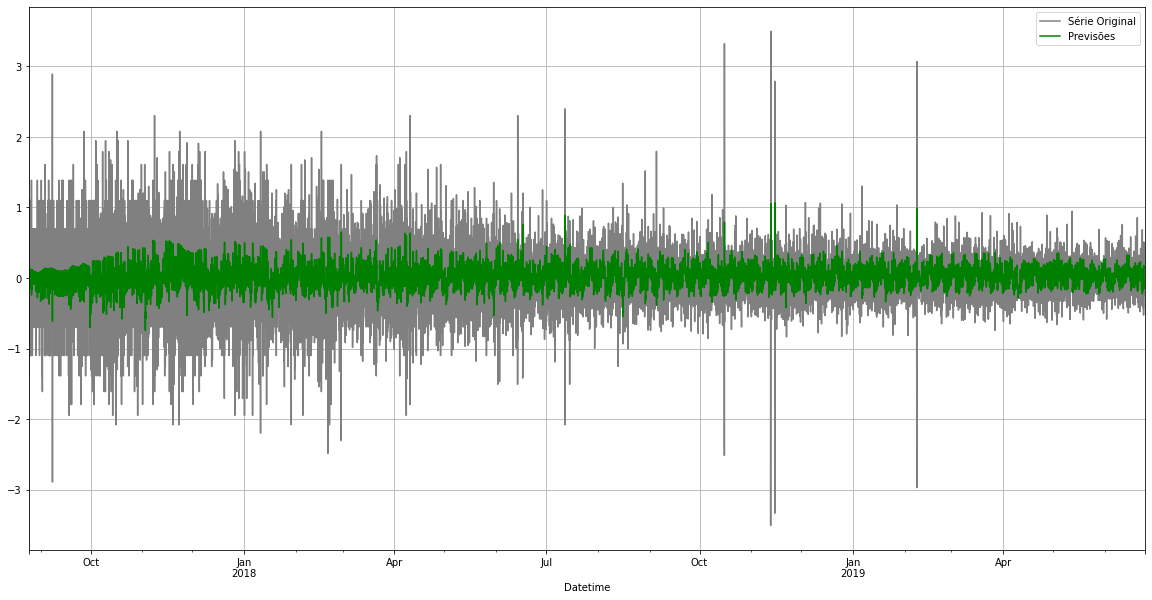

In [146]:
dados_reais.plot(color='gray', label='Série Original', grid=True)
previsoes.plot(color='green', label='Previsões', grid=True)
plt.legend(loc='best')
plt.show();

In [139]:
modelo_v1.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARIMA
====================================================================
Model:              ARIMA            BIC:                 15954.5847
Dependent Variable: D.Count          Log-Likelihood:      -7957.9   
Date:               2020-11-03 13:59 Scale:               1.0000    
No. Observations:   16056            Method:              css-mle   
Df Model:           3                Sample:              08-25-2017
Df Residuals:       16053                                 06-25-2019
Converged:          1.0000           S.D. of innovations: 0.397     
No. Iterations:     23.0000          HQIC:                15934.013 
AIC:                15923.8494                                      
---------------------------------------------------------------------
                Coef.   Std.Err.      t      P>|t|    [0.025   0.975]
---------------------------------------------------------------------
const           0.0003    0.0001     2.8687  0.0041   0.0001   0.0005
ar.L1.D.Count   0.7365    0.0060   122.3938  0.0000   0.7247   0.7483
ma.L1.D.Count  -0.9915    0.0016  -602.6793  0.0000  -0.9947  -0.9883
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1            1.3577             0.0000           1.3577             0.0000
MA.1            1.0086             0.0000           1.0086             0.0000
====================================================================

"""

##### Previsão do modelo com os dados de validação

In [140]:
df5_valida_log = np.log(df5_valida.Count)

In [141]:
forecast_v1, erro, coef = modelo_v1.forecast(len(df5_valida), alpha= 0.05) # 95% Intervalo de confiança

In [142]:
fc_series = pd.Series(forecast_v1, index=df5_valida.index)
limite_inferior = pd.Series(coef[:,0], index = df5_valida.index)
limite_superior = pd.Series(coef[:,1], index = df5_valida.index)

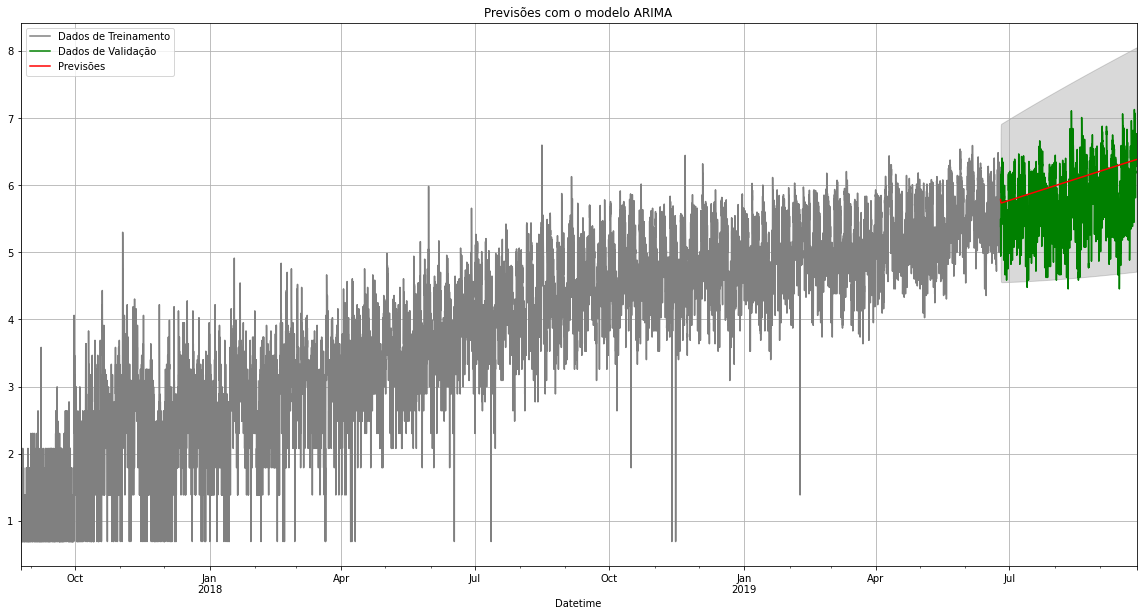

In [143]:
df5_treino_log.plot(color='gray', label='Dados de Treinamento', grid=True)
df5_valida_log.plot(color='green', label='Dados de Validação', grid=True)
fc_series.plot(color='red', label='Previsões', grid=True)
plt.fill_between(limite_inferior.index, limite_inferior, limite_superior, color = 'k', alpha = .15)
plt.title('Previsões com o modelo ARIMA')
plt.legend(loc='upper left')
plt.show();

##### Calculando a Acurácia do Modelo

In [144]:
y_true = df5_valida_log
y_pred = fc_series

In [147]:
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print('MSE das previsões é {}'.format(round(mse, 2))+
                  '\nRMSE das previsões é {}'.format(round(np.sqrt(mse), 2))+
                  '\nMAPE das previsões é {}'.format(round(mape, 2))))

In [148]:
performance(y_true,y_pred)

MSE das previsões é 0.28
RMSE das previsões é 0.52
MAPE das previsões é 7.44
